# La Guajira wind energy analysis

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [21]:
# Load datasets and inspect first rows
wind_speed = pd.read_csv("./datasets/windGuajira2019.csv", skiprows= 3)
air_density = pd.read_csv("./datasets/airDensityGuajira2019.csv", skiprows= 3)

In [22]:
# Inspect wind speed dataframe
print(wind_speed.head(), "\n\n")
print(wind_speed.info())

               time        local_time  electricity  wind_speed
0  2019-01-01 00:00  2018-12-31 19:00        0.952      13.742
1  2019-01-01 01:00  2018-12-31 20:00        0.953      13.783
2  2019-01-01 02:00  2018-12-31 21:00        0.946      13.515
3  2019-01-01 03:00  2018-12-31 22:00        0.940      13.327
4  2019-01-01 04:00  2018-12-31 23:00        0.941      13.341 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         8760 non-null   object 
 1   local_time   8760 non-null   object 
 2   electricity  8760 non-null   float64
 3   wind_speed   8760 non-null   float64
dtypes: float64(2), object(2)
memory usage: 273.9+ KB
None


In [23]:
# Inspect air density dataframe
print(air_density.head(), "\n\n")
print(air_density.info())

               time        local_time   rhoa
0  2019-01-01 00:00  2018-12-31 19:00  1.167
1  2019-01-01 01:00  2018-12-31 20:00  1.168
2  2019-01-01 02:00  2018-12-31 21:00  1.169
3  2019-01-01 03:00  2018-12-31 22:00  1.169
4  2019-01-01 04:00  2018-12-31 23:00  1.169 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time        8760 non-null   object 
 1   local_time  8760 non-null   object 
 2   rhoa        8760 non-null   float64
dtypes: float64(1), object(2)
memory usage: 205.4+ KB
None


Both dataframes contain the pair of columns `time` and `local_time`, which containing datetime information currently stored as object type, need to be coerced into the appropriate data type. However, as these dataframes contain information for the same geographical area and for the same timespan, we can join them and dispense with repeated columns.

In [24]:
wind_speed_copy = wind_speed.copy()
wind_speed_copy.drop(["time", "electricity"], axis = 1 ,inplace = True)
wind_speed_copy["local_time"] = pd.to_datetime(wind_speed_copy["local_time"])
wind_speed_copy.set_index("local_time", inplace= True)
wind_speed_copy.head()

,wind_speed
local_time,
2018-12-31 19:00:00,13.742
2018-12-31 20:00:00,13.783
2018-12-31 21:00:00,13.515
2018-12-31 22:00:00,13.327
2018-12-31 23:00:00,13.341


In [25]:
air_density_copy = air_density.copy()
air_density_copy.drop("time", axis= 1, inplace= True)
air_density_copy["local_time"] = pd.to_datetime(air_density_copy["local_time"])
air_density_copy.set_index("local_time", inplace= True)
air_density_copy.rename(columns = {"rhoa": "air_density"}, inplace = True)
air_density_copy.head()

,air_density
local_time,
2018-12-31 19:00:00,1.167
2018-12-31 20:00:00,1.168
2018-12-31 21:00:00,1.169
2018-12-31 22:00:00,1.169
2018-12-31 23:00:00,1.169


In [26]:
# Inspect both new dataframes
print(wind_speed_copy.info(), "\n\n")
print(air_density_copy.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2018-12-31 19:00:00 to 2019-12-31 18:00:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   wind_speed  8760 non-null   float64
dtypes: float64(1)
memory usage: 136.9 KB
None 


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8760 entries, 2018-12-31 19:00:00 to 2019-12-31 18:00:00
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   air_density  8760 non-null   float64
dtypes: float64(1)
memory usage: 136.9 KB
None


In [27]:
# Explicitly check null values in both dataframes
print("Null values in wind speed dataframe:\n",wind_speed_copy.isna().sum(), "\n\n")
print("Null values in air density dataframe:\n",air_density_copy.isna().sum())


Null values in wind speed dataframe:
 wind_speed    0
dtype: int64 


Null values in air density dataframe:
 air_density    0
dtype: int64


In [28]:
# Join dataframes
wind_df = wind_speed_copy.join(air_density_copy)
wind_df.head()

,wind_speed,air_density
local_time,,
2018-12-31 19:00:00,13.742,1.167
2018-12-31 20:00:00,13.783,1.168
2018-12-31 21:00:00,13.515,1.169
2018-12-31 22:00:00,13.327,1.169
2018-12-31 23:00:00,13.341,1.169


Dataset spread measures:

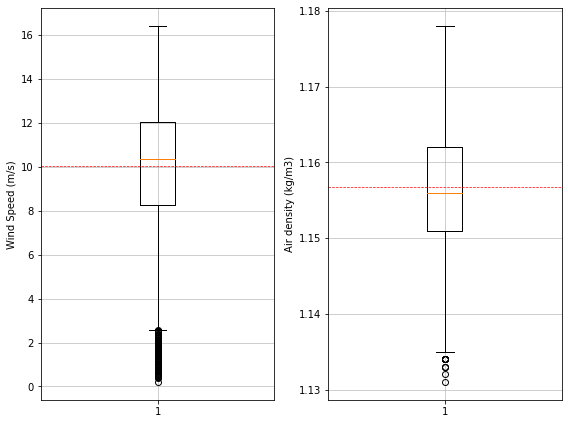

        wind_speed  air_density
count  8760.000000  8760.000000
mean     10.019084     1.156697
std       2.702837     0.008449
min       0.203000     1.131000
25%       8.253750     1.151000
50%      10.360500     1.156000
75%      12.050250     1.162000
max      16.400000     1.178000 


Variance: 
 wind_speed     7.305329
air_density    0.000071
dtype: float64


In [103]:
fig, ax = plt.subplots(1,2, figsize = (8, 6))
ax[0].boxplot(wind_df["wind_speed"])
ax[0].axhline(y = wind_df["wind_speed"].mean(), linewidth = 0.7, color = "r", linestyle = "dashed")
ax[0].set_ylabel("Wind Speed (m/s)")
ax[0].grid(linewidth = 0.6)
ax[1].boxplot(wind_df["air_density"])
ax[1].axhline(y = wind_df["air_density"].mean(), linewidth = 0.7, color = "r", linestyle = "dashed")
ax[1].set_ylabel("Air density (kg/m3)")
ax[1].grid(linewidth = 0.6)
plt.tight_layout()
plt.show()

print(wind_df.describe(), "\n\n")
print(f"Variance: \n {wind_df.var()}")

...

The power generated by wind turbines can be calculated with the formula:  

$$ 
P = \frac{1}{2} \times Air \: Density \times Rotor Swept Area \times Wind \: Speed^3 \times Efficiency
$$

Given an efficiency coefficient $ec = 0.4$, a rotor swept diameter $ \varnothing = 60m$, and the mean values from the `wind_df` we can calculate the electric power generated per wind turbine. 
To begin with, let's work out the rotor swept area from the known diameter value.

In [67]:
d = 60 # rotor swept diameter value

rs_area = np.pi * (d/2)**2

print(f"Rotor Swept Area = {rs_area} squared meters")

Rotor Swept Area = 2827.4333882308138 squared meters


...

In [125]:
air_density_mean = wind_df["air_density"].mean()
wind_speed_p50 = wind_df["wind_speed"].median()
ec = 0.4  # Efficiency coefficient

def power_gen(air_den, area, wind_s, eff_coef):
    """Work out wind turbines power generation capacity in MW"""
    return round((0.5* air_den * area * wind_s**3 * eff_coef) / 1e6, 3)

10.3605


In [126]:
mean_power_gen = power_gen(air_density_mean, rs_area, wind_speed_p50, ec)

print(f"Estimated mean power generation capacity: {mean_power_gen} MW")

Estimated mean power generation capacity: 0.727 MW


In [127]:
# Repeating the process with the 25th and 75th percentiles of wind speed.
wind_speed_p25 = np.quantile(wind_df["wind_speed"], 0.25)
wind_speed_p75 = np.quantile(wind_df["wind_speed"], 0.75)

power_gen_p25 = power_gen(air_density_mean, rs_area, wind_speed_p25, ec)
power_gen_p75 = power_gen(air_density_mean, rs_area, wind_speed_p75, ec)

print(f"25th percentile estimated power generation capacity: {power_gen_p25} MW")
print(f"75th percentile estimated mean power generation capacity: {power_gen_p75} MW")

25th percentile estimated power generation capacity: 0.368 MW
75th percentile estimated mean power generation capacity: 1.145 MW


...

In [131]:
wind_df_copy = wind_df.copy()

wind_df_copy["power_gen"] = round((0.5 * wind_df_copy["air_density"] * rs_area * wind_df_copy["wind_speed"]**3 * ec) / 1000000, 3)

wind_df_copy.head()

,wind_speed,air_density,power_gen
local_time,,,
2018-12-31 19:00:00,13.742,1.167,1.713
2018-12-31 20:00:00,13.783,1.168,1.729
2018-12-31 21:00:00,13.515,1.169,1.632
2018-12-31 22:00:00,13.327,1.169,1.565
2018-12-31 23:00:00,13.341,1.169,1.570


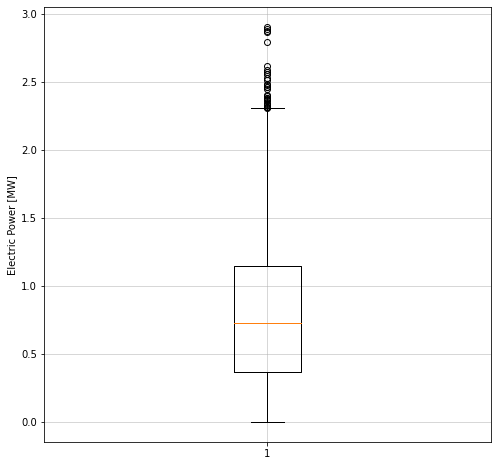

count    8760.000000
mean        0.794108
std         0.514372
min         0.000000
25%         0.368000
50%         0.729000
75%         1.144000
max         2.907000
Name: power_gen, dtype: float64


In [136]:
fig, ax = plt.subplots(figsize = (8,8))
ax.boxplot(wind_df_copy["power_gen"])
ax.set_ylabel("Electric Power [MW]")
ax.grid(linewidth=0.5)
plt.show()

print(wind_df_copy["power_gen"].describe())

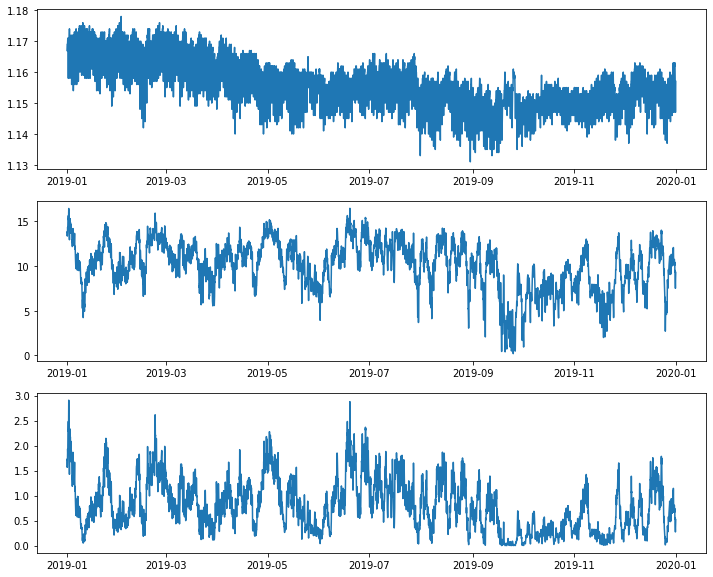

In [141]:
fig, ax = plt.subplots(3,1,figsize = (12,10))
ax[0].plot(wind_df_copy.index, wind_df_copy["air_density"])
ax[1].plot(wind_df_copy.index, wind_df_copy["wind_speed"])
ax[2].plot(wind_df_copy.index, wind_df_copy["power_gen"])
plt.show()